<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [46]:
import gc
import pickle
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utilities import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

pd.options.mode.chained_assignment = None

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the Dataset

In [2]:
df = pd.read_csv('data/network_backup_dataset.csv')

In [3]:
df.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour)
0,1,Monday,1,work_flow_0,File_0,0.0,0
1,1,Monday,1,work_flow_2,File_12,0.0,0
2,1,Monday,1,work_flow_2,File_13,0.0,0
3,1,Monday,1,work_flow_2,File_14,0.0,0
4,1,Monday,1,work_flow_2,File_16,0.0,0


In [4]:
df.drop('Backup Time (hour)', axis=1, inplace=True)
df.columns = ['week', 'dow', 'hod', 'id', 'name', 'target']

In [5]:
dayOfWeek={'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['dow'] = df['dow'].map(dayOfWeek)

In [6]:
features = df.columns.values.tolist()[:5]

lb_en = LabelEncoder()
for feature in features:  # Just label-encode everything.
    df[feature] = lb_en.fit_transform(df[feature])

In [8]:
df.head()

,week,dow,hod,id,name,target
0,0,0,0,0,0,0.0
1,0,0,0,2,4,0.0
2,0,0,0,2,5,0.0
3,0,0,0,2,6,0.0
4,0,0,0,2,8,0.0


## (a)

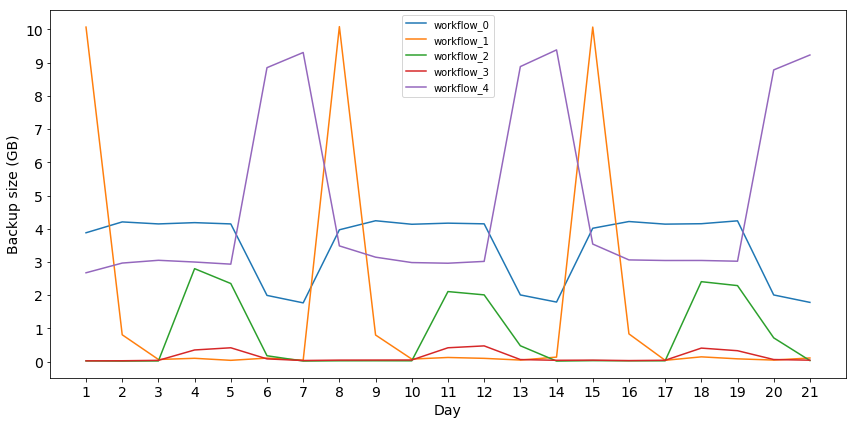

In [9]:
data = df.groupby(['week', 'dow', 'id']).agg({'target': 'sum'}).unstack()
data.columns = ["workflow_" + str(x) for x in data.columns.get_level_values(1).tolist()]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
for i in range(5):
    ax.plot(np.arange(21), data.iloc[:21, i])

ax.set_xticks(np.arange(21))
ax.set_xticklabels(np.arange(21)+1, fontdict={'fontsize': 14})
ax.set_xlabel('Day', fontdict={'fontsize': 14})
ax.set_yticks(np.arange(11))
ax.set_yticklabels(np.arange(11), fontdict={'fontsize': 14})
ax.set_ylabel('Backup size (GB)', fontdict={'fontsize': 14})
ax.legend()

fig.tight_layout()
fig.savefig('report/figures/1-a.png', dpi=300)

## (b)

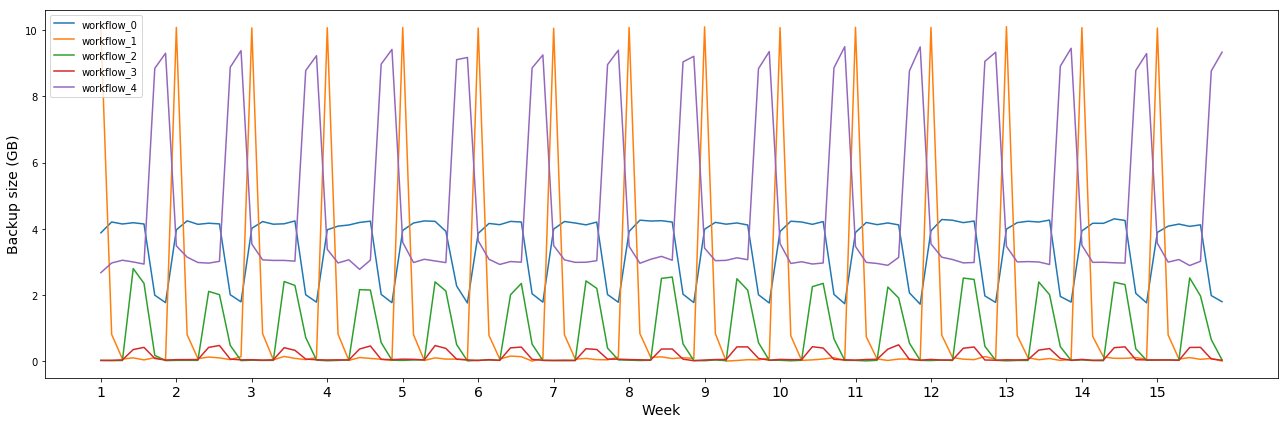

In [182]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
for i in range(5):
    ax.plot(np.arange(105), data.iloc[:, i])

ax.set_xticks(np.arange(0, 105, 7))
ax.set_xticklabels(np.arange(15)+1, fontdict={'fontsize': 14})
ax.set_xlabel('Week', fontdict={'fontsize': 14})
# ax.set_yticks(np.arange(11))
# ax.set_yticklabels(np.arange(11), fontdict={'fontsize': 14})
ax.set_ylabel('Backup size (GB)', fontdict={'fontsize': 14})
ax.legend()

fig.tight_layout()
fig.savefig('report/figures/1-b.png', dpi=300)

# Predict
## (a) Linear
### i)

In [9]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x.values, y.values, clf_lr)  # pass ndarray instead of dataframe
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.101967
test rmse: 0.102391


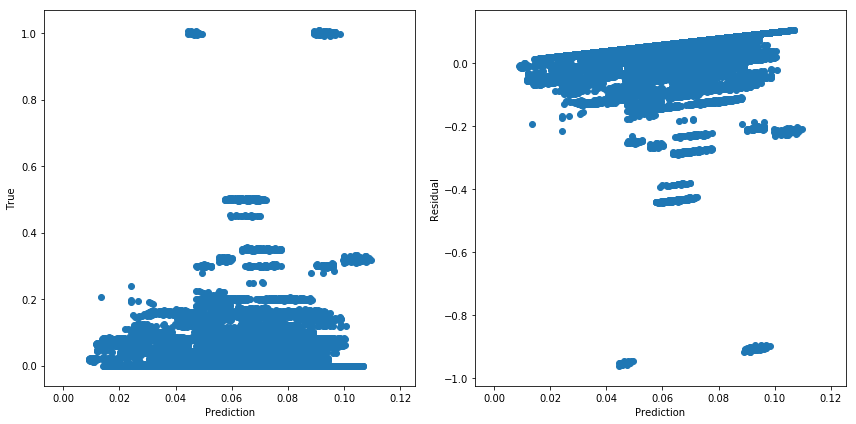

In [10]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-i.png")

### ii)

TODO: figure out the difference of standardization and normalization in Sklearn

In [11]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)  # already an ndarray

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_scaled, y, clf_lr)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.101967
test rmse: 0.102391


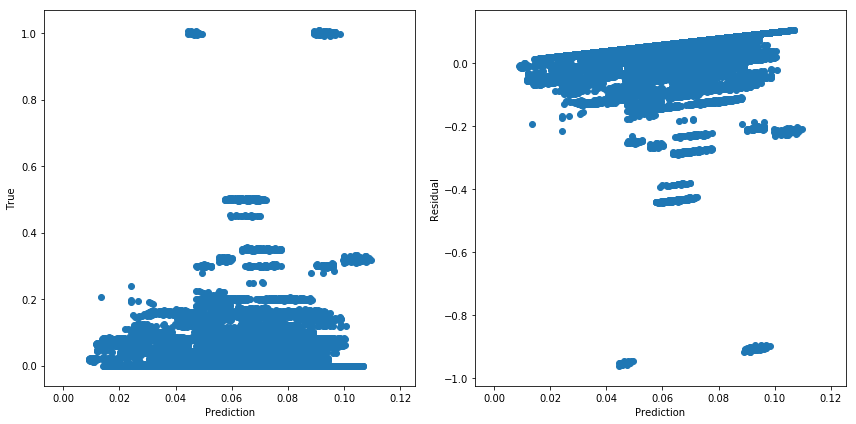

In [12]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-ii.png")

### iii)

In [13]:
results = f_regression(x, y)
for i, feature in enumerate(features):
    print("%s fscore: %f and p-value: %.2E" %(feature, results[0][i], results[1][i]))
    
print('% ------------------------------------------------------')

results = mutual_info_regression(x, y, discrete_features=True)
for i, feature in enumerate(features):

    print("%s mutual information score: %f" %(feature, results[i]))

week fscore: 0.008450 and p-value: 9.27E-01
dow fscore: 38.816380 and p-value: 4.76E-10
hod fscore: 150.740934 and p-value: 1.62E-34
id fscore: 26.138665 and p-value: 3.21E-07
name fscore: 460.786474 and p-value: 5.45E-101
% ------------------------------------------------------
week mutual information score: 0.000000
dow mutual information score: 0.234832
hod mutual information score: 0.299508
id mutual information score: 0.772289
name mutual information score: 0.769219


In [14]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

x_f_reg = x[['dow', 'hod', 'name']]

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_f_reg.values, y, clf_lr)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.101995
test rmse: 0.102402


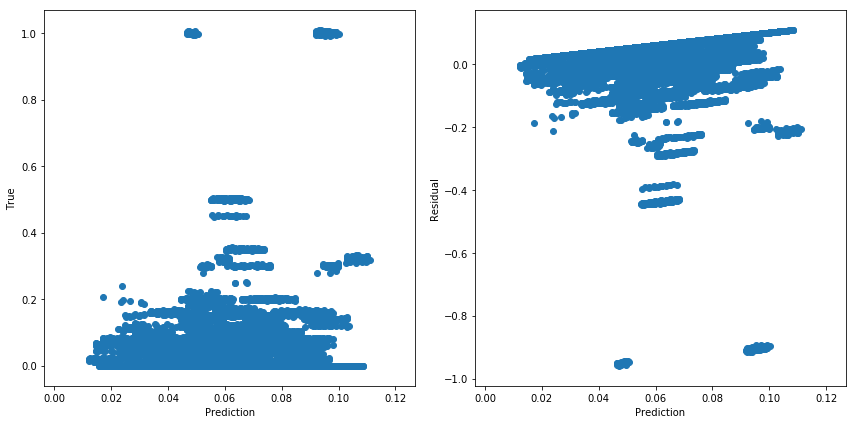

In [15]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-iii-freg.png")

In [16]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

x_mi = x[['id', 'hod', 'name']]

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_mi.values, y, clf_lr)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.102089
test rmse: 0.102489


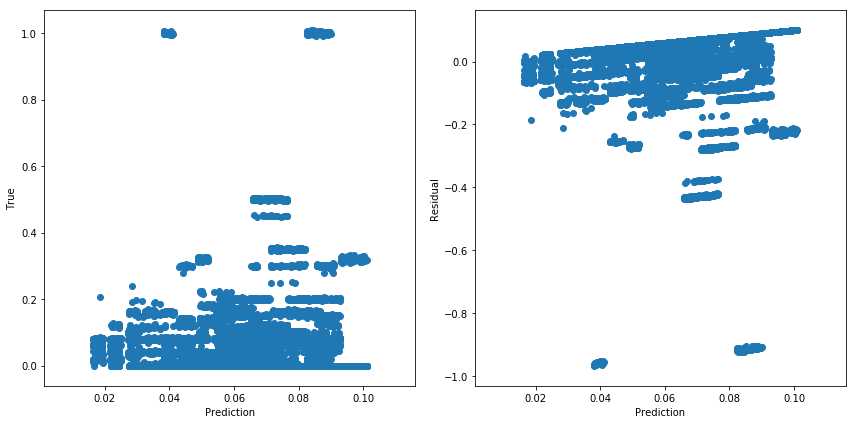

In [17]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-iii-mi.png")

### iv)

In [40]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)

ohe that produces best train:  ['dow', 'hod', 'id', 'name']
ohe that produces best test:  ['dow', 'hod', 'id']


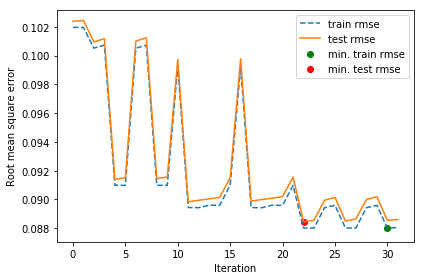

In [41]:
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-iv.png')

### v)

Ridge

ohe that produces best train:  ['week', 'dow', 'hod', 'id', 'name']
ohe that produces best test:  ['dow', 'hod', 'id']


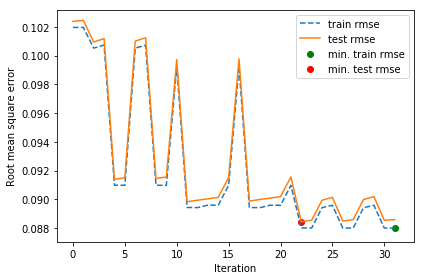

In [38]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = Ridge()

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-v-ridge.png')

In [20]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
tst_rmses = np.zeros((len(alphas), ))

x_temp = one_hot_encode(x, ['dow', 'hod', 'id'])

for i, alpha in enumerate(alphas):
    clf_lr = Ridge(alpha=alpha)
    y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_temp.values, y, clf_lr)
    tst_rmses[i] = np.sqrt(mean_squared_error(y, y_pred))

print('best RMSE = %f at alpha = %0.1E' %(np.min(tst_rmses), alphas[np.argmin(tst_rmses)]))

best RMSE = 0.088445 at alpha = 1.0E+01


Lasso

ohe that produces best train:  ['week', 'dow', 'hod', 'id', 'name']
ohe that produces best test:  ['week', 'dow', 'hod', 'id']


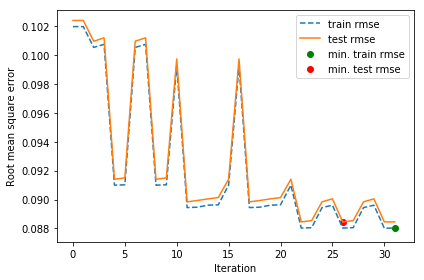

In [12]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = Lasso(alpha=1e-4)

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-v-Lasso.png')

In [22]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
alphas = np.arange(1, 11) * 1e-4
tst_rmses = np.zeros((len(alphas), ))

x_temp = one_hot_encode(x, ['week', 'dow', 'hod', 'id'])

for i, alpha in enumerate(alphas):
    clf_lr = Lasso(alpha=alpha)
    y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_temp.values, y, clf_lr)
    tst_rmses[i] = np.sqrt(mean_squared_error(y, y_pred))

print('best RMSE = %f at alpha = %0.1E' %(np.min(tst_rmses), alphas[np.argmin(tst_rmses)]))

best RMSE = 0.088449 at alpha = 1.0E-04


ElasticNet

ohe that produces best train:  ['week', 'dow', 'hod', 'id', 'name']
ohe that produces best test:  ['dow', 'hod', 'id']


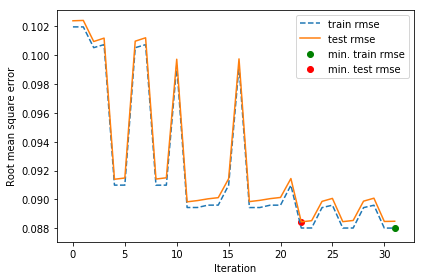

In [23]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = ElasticNet(alpha=1e-4)

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-v-ElasticNet.png')

In [30]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
alphas = np.arange(1, 11) * 1e-4
l1_ratios = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
tst_rmses = []
x_temp = one_hot_encode(x, ['dow', 'hod', 'id'])

for i, (alpha, l1_ratio) in enumerate(zip(alphas,l1_ratios)):
    clf_lr = ElasticNet(alpha)
    y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_temp.values, y, clf_lr)
    tst_rmses.append(np.sqrt(mean_squared_error(y, y_pred)))
    
print('best RMSE = %f at alpha = %0.1E and l1_ratio = %0.1E' %(np.min(tst_rmses), alphas[np.argmin(tst_rmses)//len(alphas)],
                                                              l1_ratios[np.argmin(tst_rmses)%len(l1_ratios)]))

best RMSE = 0.088446 at alpha = 1.0E-04 and l1_ratio = 1.0E-07


In [33]:
a = Lasso(1e-4)


I:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


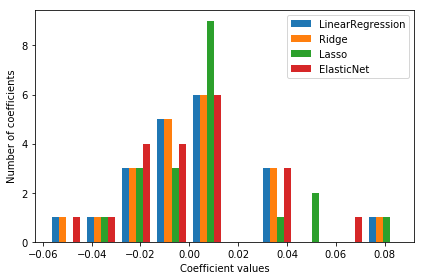

In [50]:
clfs = [LinearRegression(), Ridge(alpha=1e1), Lasso(alpha=1e-4), ElasticNet(alpha=1e-4, l1_ratio=1e-7)]
coefs = []

for i, clf in enumerate(clfs):
    clf.fit(one_hot_encode(x, ['dow', 'hod', 'id']).values, y)
    coefs.append(clf.coef_)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.array(coefs).transpose())
ax.legend([type(x).__name__ for x in clfs])
ax.set_xlabel('Coefficient values')
ax.set_ylabel('Number of coefficients')

plt.tight_layout()
plt.savefig('report/figures/2-a-v-coef.png', dpi=300)

## (b) Random Forest

### (i)

In [7]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_forest = RandomForestRegressor(n_estimators=20,max_features=5, max_depth=4, oob_score=True)

y_pred, trn_rmse, oob_error = cross_validate_custom_forest(nfolds, seed, x.values, y, clf_forest)  # pass ndarray instead of dataframe
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

In [8]:
print('Average train RMSE: {}'.format(trn_rmse))
print('Average test RMSE: {}'.format(tst_rmse))
print('Average OOB Error: {}'.format(oob_error))

Average train RMSE: 0.060150760038903364
Average test RMSE: 0.060286307985754066
Average OOB Error: 0.33628468261517697


### (ii)

In [39]:
num_tree_lst = np.arange(1, 201, 1)
k_lst = [1,2,3,4,5]
oob_error_tree = []
tst_rmse_tree = []
seed = 42
nfolds = 10
x = df[features]
y = df['target']

for num in num_tree_lst:
    oob_error_lst = []
    tst_rmse_lst = []
    for k in k_lst:
        clf_forest = RandomForestRegressor(n_estimators=num,max_features=k, max_depth=4, oob_score=True)

        y_pred, trn_rmse, oob_score = cross_validate_custom_forest(nfolds, seed, x.values, y, clf_forest)
        tst_rmse = np.sqrt(mean_squared_error(y, y_pred))
        tst_rmse_lst.append(tst_rmse)
        oob_error_lst.append(oob_score)
    oob_error_tree.append(oob_error_lst)
    tst_rmse_tree.append(tst_rmse_lst)
    print('Current Iteration: Num Trees {0}, Num Features {1}'.format(num, k))


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 1, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 2, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 3, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 4, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 5, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 6, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 7, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 8, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 9, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 10, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 11, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 12, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 13, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 14, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 15, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 16, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 17, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 18, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 19, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 20, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 21, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 22, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 23, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 24, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 25, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Current Iteration: Num Trees 26, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Num Trees 27, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Current Iteration: Num Trees 28, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Current Iteration: Num Trees 29, Num Features 5
Current Iteration: Num Trees 30, Num Features 5
Current Iteration: Num Trees 31, Num Features 5


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Current Iteration: Num Trees 32, Num Features 5
Current Iteration: Num Trees 33, Num Features 5
Current Iteration: Num Trees 34, Num Features 5
Current Iteration: Num Trees 35, Num Features 5
Current Iteration: Num Trees 36, Num Features 5
Current Iteration: Num Trees 37, Num Features 5
Current Iteration: Num Trees 38, Num Features 5
Current Iteration: Num Trees 39, Num Features 5
Current Iteration: Num Trees 40, Num Features 5
Current Iteration: Num Trees 41, Num Features 5
Current Iteration: Num Trees 42, Num Features 5
Current Iteration: Num Trees 43, Num Features 5
Current Iteration: Num Trees 44, Num Features 5
Current Iteration: Num Trees 45, Num Features 5
Current Iteration: Num Trees 46, Num Features 5
Current Iteration: Num Trees 47, Num Features 5
Current Iteration: Num Trees 48, Num Features 5
Current Iteration: Num Trees 49, Num Features 5
Current Iteration: Num Trees 50, Num Features 5
Current Iteration: Num Trees 51, Num Features 5
Current Iteration: Num Trees 52, Num Fea

In [40]:
pickle.dump(oob_error_tree, open('results/2bii_numTrees_oob', 'wb'))
pickle.dump(tst_rmse_tree, open('results/2bii_numTrees_tstRMSE', 'wb'))

In [ ]:
oob_error_tree = pickle.load( open( "results/2bii_numTrees_oob", "rb" ) )
tst_rmse_tree = pickle.load( open( "results/2bii_numTrees_tstRMSE", "rb" ) )

Number of Tree with min OOB Error: 170


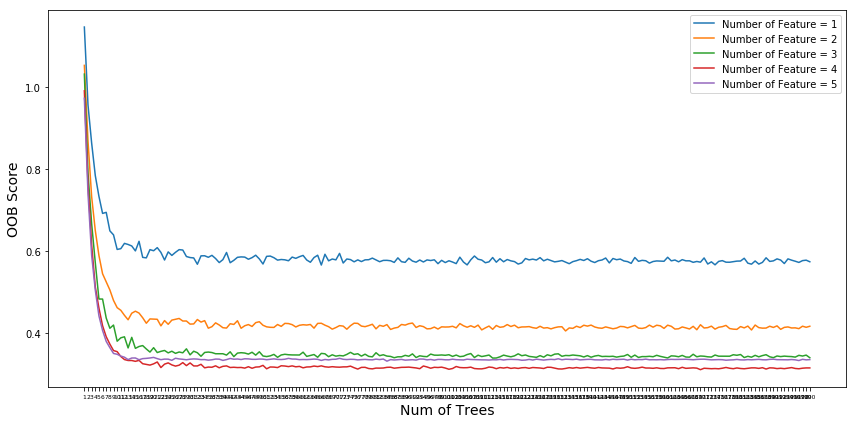

In [45]:
x_oob = np.array(oob_error_tree)
print('Number of Tree with min OOB Error: {}'.format(num_tree_lst[np.argmin(x_oob[:,3])]))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
for k in k_lst:
    ax.plot(np.arange(np.max(num_tree_lst)), x_oob[:,k-1])

ax.set_xticks(np.arange(np.max(num_tree_lst)))
ax.set_xticklabels(np.arange(np.max(num_tree_lst))+1, fontdict={'fontsize': 6})
ax.set_xlabel('Num of Trees', fontdict={'fontsize': 14})
#ax.set_yticks(np.arange(11))
#ax.set_yticklabels(np.arange(11), fontdict={'fontsize': 14})
ax.set_ylabel('OOB Score', fontdict={'fontsize': 14})
ax.legend(['Number of Feature = ' + format(i) for i in k_lst ], loc='upper right')

fig.tight_layout()
fig.savefig('report/figures/2-b(ii)-oob.png', dpi=300)

Number of Tree with min Test RMSE: 22


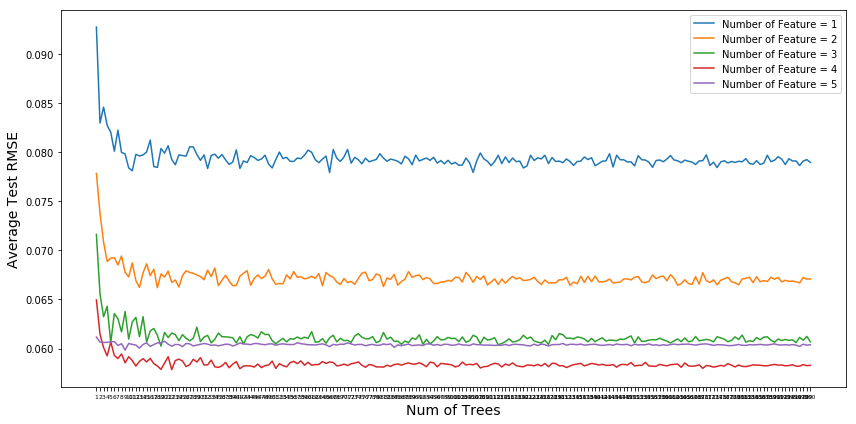

In [44]:
x_rmse = np.array(tst_rmse_tree)
print('Number of Tree with min Test RMSE: {}'.format(num_tree_lst[np.argmin(x_rmse[:,3])]))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
for k in k_lst:
    ax.plot(np.arange(np.max(num_tree_lst)), x_rmse[:,k-1])

ax.set_xticks(np.arange(np.max(num_tree_lst)))
ax.set_xticklabels(np.arange(np.max(num_tree_lst))+1, fontdict={'fontsize': 6})
ax.set_xlabel('Num of Trees', fontdict={'fontsize': 14})
ax.set_ylabel('Average Test RMSE', fontdict={'fontsize': 14})
ax.legend(['Number of Feature = ' + format(i) for i in k_lst ], loc='upper right')

fig.tight_layout()
fig.savefig('report/figures/2-b(ii)-tstRMSE.png', dpi=300)

## (iii)

#### We choose to play with max depth of the tree and the max number of leaf nodes

In [27]:
num_tree = 20
k = 4
oob_lst_tree = []
seed = 42
nfolds = 10
x = df[features]
y = df['target']

oob_error_tree = []
tst_rmse_tree = []
num_depth = np.arange(4,13,1) # from depth 4 to 12
num_leaf = np.arange(30,101,1) # from 30 leaf nodes to 100 leaf nodes
for depth in num_depth:
    oob_error_lst = []
    tst_rmse_lst = []
    for leaf in num_leaf:
        clf_forest = RandomForestRegressor(n_estimators=num_tree,
                                           max_features=k,
                                           max_depth=depth,
                                           max_leaf_nodes=leaf,
                                           oob_score=True)

        y_pred, trn_rmse, oob_score = cross_validate_custom_forest(nfolds, seed, x.values, y, clf_forest)
        tst_rmse = np.sqrt(mean_squared_error(y, y_pred))
        tst_rmse_lst.append(tst_rmse)
        oob_error_lst.append(oob_score)

    oob_error_tree.append(oob_error_lst)
    tst_rmse_tree.append(tst_rmse_lst)
    print('Current Iteration: Depth {0}, Leaf {1}'.format(depth, leaf))


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 4, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 5, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 6, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 7, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 8, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 9, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 10, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 11, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

Current Iteration: Depth 12, Leaf 100


/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [ ]:
#pickle.dump(oob_error_tree, open('results/2biii_depth_oob', 'wb'))
#pickle.dump(tst_rmse_tree, open('results/2biii_depth_tstRMSE', 'wb'))

In [28]:
oob_error_tree = pickle.load( open( "results/2biii_depth_oob", "rb" ) )
tst_rmse_tree = pickle.load( open( "results/2biii_depth_tstRMSE", "rb" ) )

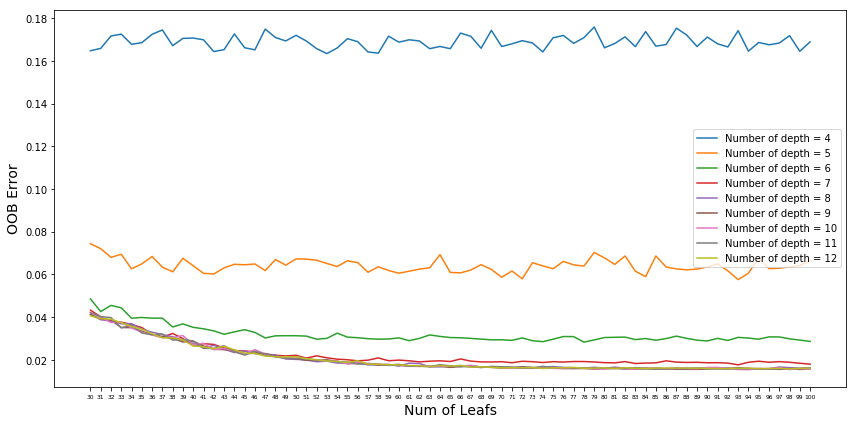

In [29]:
x_oob = np.array(oob_error_tree)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
for i,depth in enumerate(num_depth):
    ax.plot(np.arange(np.min(num_leaf),np.max(num_leaf)+1,1), x_oob[i,:])

ax.set_xticks(np.arange(np.min(num_leaf),np.max(num_leaf)+1,1))
ax.set_xticklabels(np.arange(np.min(num_leaf),np.max(num_leaf)+1,1), fontdict={'fontsize': 6})
ax.set_xlabel('Num of Leafs', fontdict={'fontsize': 14})
ax.set_ylabel('OOB Error', fontdict={'fontsize': 14})
ax.legend(['Number of depth = ' + format(i) for i in num_depth ], loc=7)

fig.tight_layout()
fig.savefig('report/figures/2-b(iii)-oob.png', dpi=300)

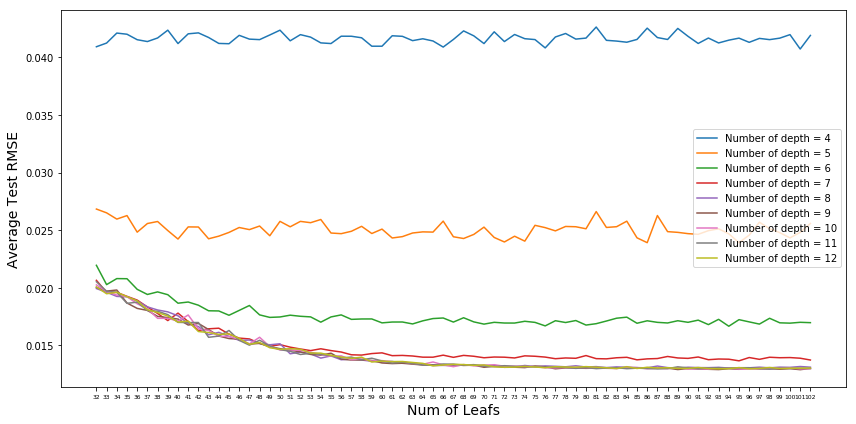

In [30]:
x_rmse = np.array(tst_rmse_tree)
#print(num_tree_lst[np.argmin(x_rmse[:,3])])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
for i,depth in enumerate(num_depth):
    ax.plot(np.arange(np.min(num_leaf),np.max(num_leaf)+1,1), x_rmse[i,:])

ax.set_xticks(np.arange(np.min(num_leaf),np.max(num_leaf)+1,1))
ax.set_xticklabels(np.arange(np.min(num_leaf),np.max(num_leaf)+1,1)+2, fontdict={'fontsize': 6})
ax.set_xlabel('Num of Leafs', fontdict={'fontsize': 14})
#ax.set_yticks(np.arange(11))
#ax.set_yticklabels(np.arange(11), fontdict={'fontsize': 14})
ax.set_ylabel('Average Test RMSE', fontdict={'fontsize': 14})
ax.legend(['Number of depth = ' + format(i) for i in num_depth ], loc=7)

fig.tight_layout()
fig.savefig('report/figures/2-b(iii)-tstRMSE.png', dpi=300)

In [31]:
min_k = np.max([np.argmax(x_rmse[8,:] - np.min(x_rmse[8,:]) <= 2e-3), np.argmax(x_oob[8,:] - np.min(x_oob[8,:]) <= 2e-3)])
print(num_leaf[min_k])

59


### We can see that tree depths greater than 8 show no significant decrease in OOB error or Test RMSE. So we choose the depth of our random tree regressor to be 8. Additionally, we choose the number of leaves to be 60, corresponding to where there is no significant decrease in both error measures.

## (iv)

#### Best Parameters We have Chosen:

    Number of Trees: 20
    Max Number of Features: 4
    Max Depth: 8
    Max Number of Leaf Nodes: 60

In [48]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_forest = RandomForestRegressor(n_estimators=20,max_features=4, max_depth=8, max_leaf_nodes=60, oob_score=True)

y_pred, trn_rmse, oob_error = cross_validate_custom_forest(nfolds, seed, x.values, y, clf_forest)  # pass ndarray instead of dataframe
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alexwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

train rmse: 0.013069
test rmse: 0.013509


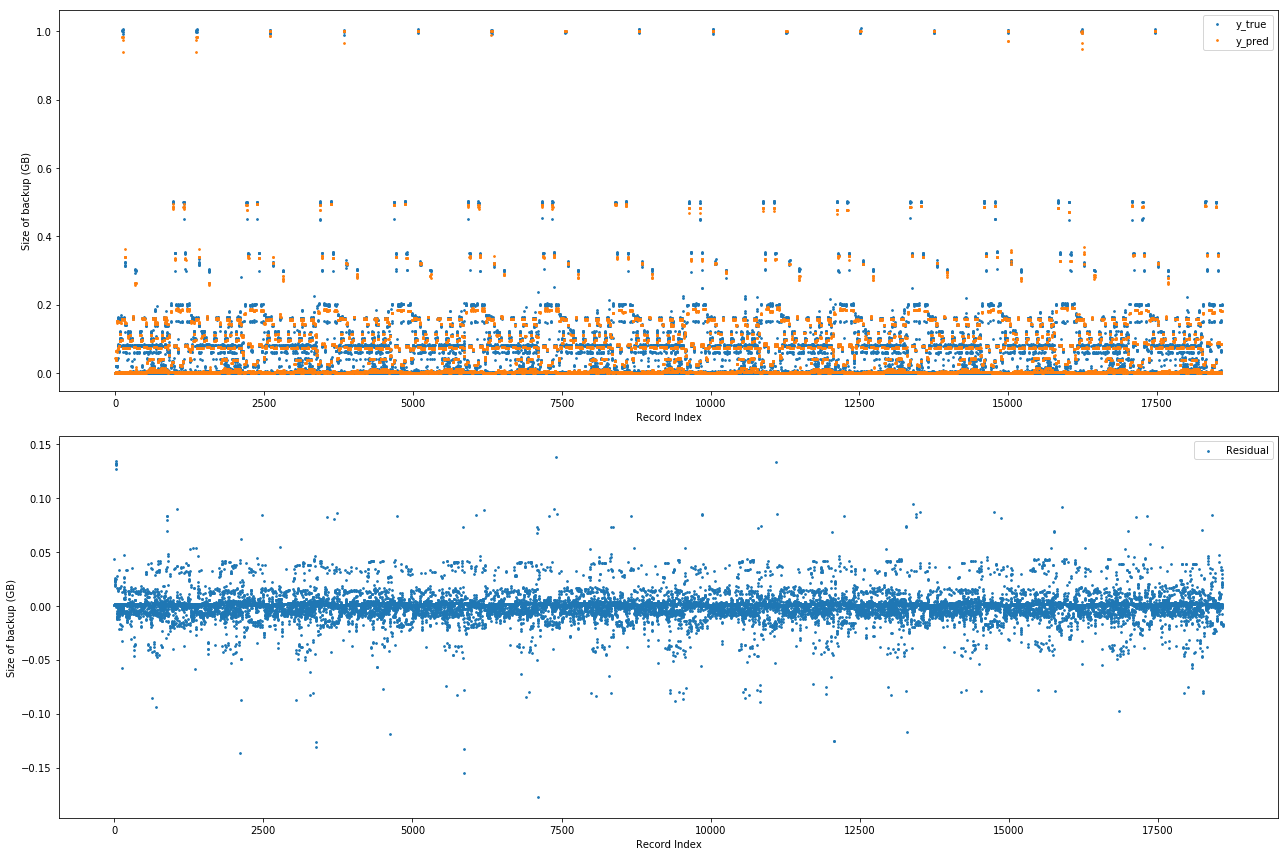

In [49]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-b-iv-best.png")

In [50]:
print('Performance of our Best Model:')
print('\tAverage train RMSE: {}'.format(trn_rmse))
print('\tAverage test RMSE: {}'.format(tst_rmse))
print('\tAverage OOB Error: {}'.format(oob_error))

Performance of our Best Model:
	Average train RMSE: 0.01306901096707751
	Average test RMSE: 0.013509482744282725
	Average OOB Error: 0.01764303222590786


In [51]:
print('Features in the order of importance:\n')

for i in np.argsort(-np.array(clf_forest.feature_importances_)):
    print('\t{0}: {1}'.format(features[i], clf_forest.feature_importances_[i]))

Features in the order of importance:

	hod: 0.3921592344685159
	id: 0.31278301340088555
	dow: 0.22074443638684538
	name: 0.07220600593010038
	week: 0.0021073098136528516


## (v)

In [22]:
x = df[features]
y = df['target']
clf_forest = RandomForestRegressor(n_estimators=20,max_features=4, max_depth=4, max_leaf_nodes=60, oob_score=False)
clf_forest = clf_forest.fit(x.values,y)

for i,tree in enumerate(clf_forest.estimators_):
    export_graphviz(tree,
                feature_names=features,
                filled=True,
                rounded=True,
                out_file=None)
                #out_file='tree_{0}.png'.format(i))
    os.system('dot -Tpng tree.dot -o report/figures/tree_{0}.png'.format(i))
print('Done')

Done


#### From the plots of the regression trees (20 of them), we can see that the node of the trees might not correspond to the most important feature that the regressor reports (e.g tree 4,5,9,10,12,16,17). This is because that scikit learn's feature importance is implemented by measuring the decrease of impurity of nodes (meaning pure nodes are deemed more important) and weighted by the samples it splits. However, we fit our model according to accuracy measure. A pure node that can split data into a pure left or right branch may not guaranteed to yield a model with best accuracy. This is because if the number of samples in one of the pure branch is quite small then the actual accuracy gain for that branch will not be great.

## (c) Neural Network

## (d) Predict each workflow seperately

## (e) kNN